In [1]:
import os

import numpy as np
import pandas as pd
import PIL.Image
from IPython.display import Image
import cv2
from keras.utils import np_utils
import tensorflow as tf


Using TensorFlow backend.


# init stuff

In [2]:
# path_to_data="../training_data/"
# path_to_model="../model_data/"
# path_to_forms = "../test/example_forms/unihack/"
# path_to_code = "../"


from google.colab import drive
drive.mount('/content/drive')
path_to_data="/content/drive/My Drive/UniHack/Notebooks and data/"
path_to_model = "/content/drive/My Drive/UniHack/Notebooks and data/model/"
path_to_forms = "/content/drive/My Drive/UniHack/Notebooks and data/forms/"
path_to_code = "/content/drive/My Drive/UniHack/fast-form/"

import sys
sys.path += [path_to_code]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# TYPE="numbers"
TYPE="letters"

def is_the_type(x):
    return ord("A") <= x <= ord("Z")
    # return ord("0") <= x <= ord("9")


with open(path_to_data + "emnist-balanced-mapping.txt") as f:
    s = f.read()[:-1] # remove last char \n
a = [l.split(" ") for l in s.split("\n")]
original_mapper = {int(l[0]): chr(int(l[1])) for l in a if is_the_type(int(l[1]))}



num_classes = len(original_mapper)

to_substract = min(original_mapper.keys())

res_mapper = {k - to_substract: v for k,v in original_mapper.items()}



def filter_type(df):
    return df[df.iloc[:,0].apply(lambda x: x in original_mapper.keys())]



# Model training

## load dataset

In [0]:
train_loaded  = pd.read_csv(path_to_data + "emnist-balanced-train.csv")

In [0]:
IMAGE_SIZE = 28
train_filtered = filter_type(train_loaded)

from sklearn.model_selection import train_test_split

y_all = train_filtered.iloc[:, 0] - to_substract
X_all = train_filtered.iloc[:,1:].values.reshape([len(train_filtered),IMAGE_SIZE,IMAGE_SIZE,1])/255

X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.1, random_state=42)

train_size = X_train.shape[0]
validation_size = X_val.shape[0] 

## Model definition

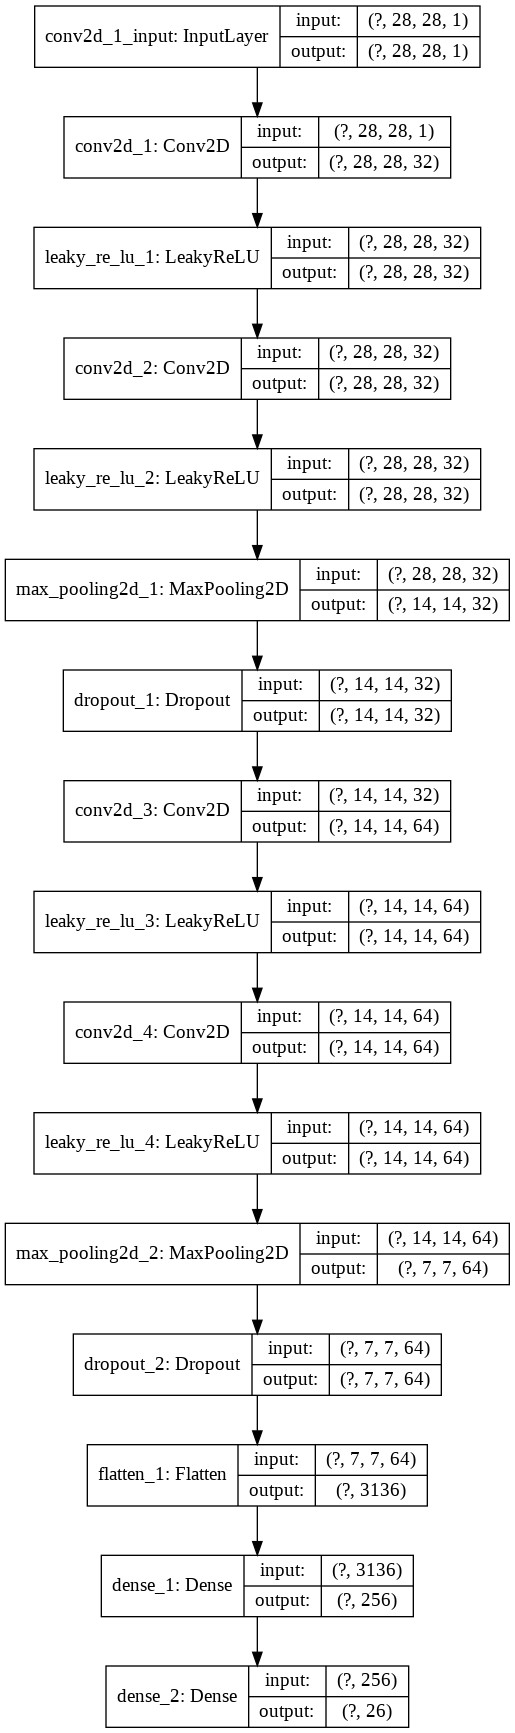

In [6]:
from keras.layers import Conv2D, Input, LeakyReLU, Dense, Activation, Flatten, Dropout, MaxPool2D
from keras import models
from keras.optimizers import Adam,RMSprop 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
model = models.Sequential()
# Block 1
model.add(Conv2D(32,3, padding  ="same",input_shape=(28,28,1)))
model.add(LeakyReLU())
model.add(Conv2D(32,3, padding  ="same"))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64,3, padding  ="same"))
model.add(LeakyReLU())
model.add(Conv2D(64,3, padding  ="same"))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(num_classes,activation="softmax"))

initial_lr = 0.001
loss = "sparse_categorical_crossentropy"
model.compile(Adam(lr=initial_lr), loss=loss ,metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False, # randomly flip images
        ) 

datagen.fit(X_train)


lrr = ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.5, min_lr=0.00001)

In [8]:
epochs = 20
batch_size = 256
# history = model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(X_val, y_val))

history = model.fit_generator(
    datagen.flow(X_train,y_train, batch_size=batch_size),
    steps_per_epoch=int(X_train.shape[0]*0.9/batch_size)+1,
    epochs=epochs,
    callbacks=[lrr],
    validation_data= (X_val, y_val)
    )

Epoch 1/20
198/198 [==============================] - 12s 63ms/step - loss: 1.2330 - accuracy: 0.6297 - val_loss: 0.3150 - val_accuracy: 0.9058
Epoch 2/20
198/198 [==============================] - 11s 56ms/step - loss: 0.4506 - accuracy: 0.8591 - val_loss: 0.2226 - val_accuracy: 0.9287
Epoch 3/20
198/198 [==============================] - 11s 57ms/step - loss: 0.3390 - accuracy: 0.8929 - val_loss: 0.1855 - val_accuracy: 0.9409
Epoch 4/20
198/198 [==============================] - 11s 57ms/step - loss: 0.2843 - accuracy: 0.9078 - val_loss: 0.1634 - val_accuracy: 0.9476
Epoch 5/20
198/198 [==============================] - 11s 55ms/step - loss: 0.2594 - accuracy: 0.9156 - val_loss: 0.1512 - val_accuracy: 0.9503
Epoch 6/20
198/198 [==============================] - 11s 56ms/step - loss: 0.2396 - accuracy: 0.9218 - val_loss: 0.1516 - val_accuracy: 0.9510
Epoch 7/20
198/198 [==============================] - 11s 55ms/step - loss: 0.2275 - accuracy: 0.9258 - val_loss: 0.1563 - val_accuracy:

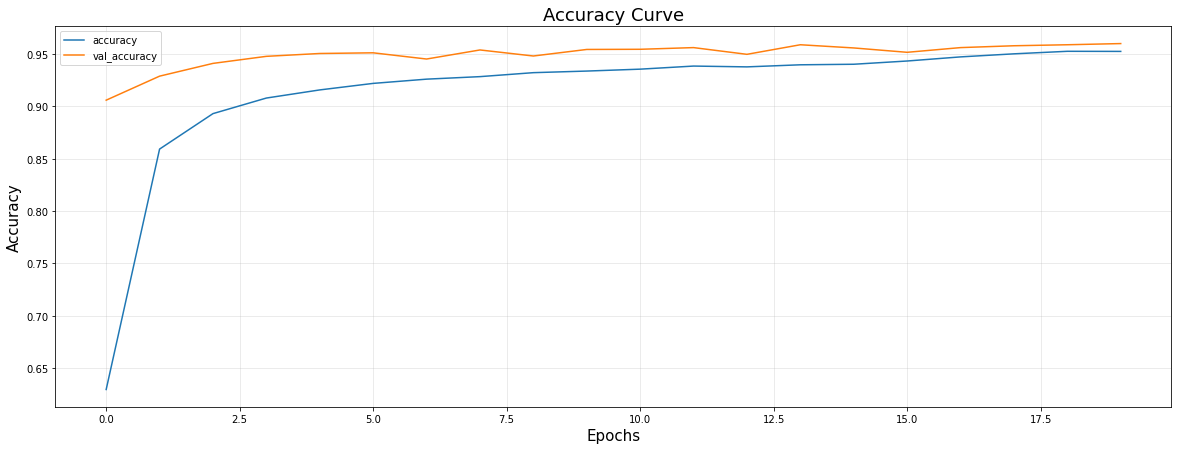

In [9]:
import matplotlib.pyplot as plt

# Diffining Figure
f = plt.figure(figsize=(20,7))

#Adding Subplot 1 (For Accuracy)
f.add_subplot(111)

plt.plot(history.epoch,history.history['accuracy'],label = "accuracy") # Accuracy curve for training set
plt.plot(history.epoch,history.history['val_accuracy'],label = "val_accuracy") # Accuracy curve for validation set

plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

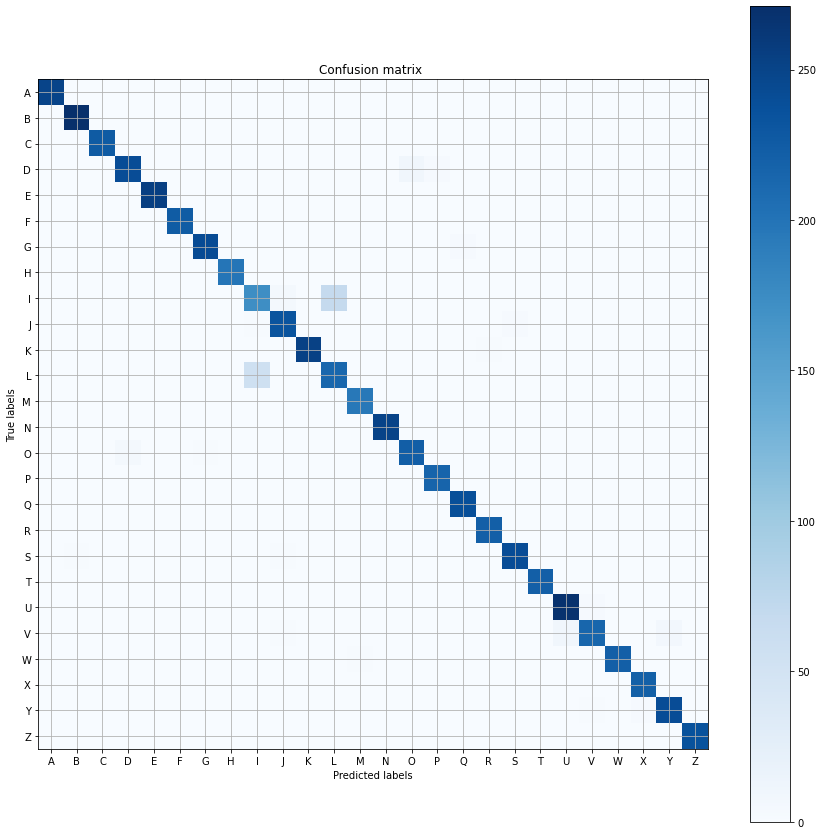

              precision    recall  f1-score   support

           A       1.00      0.99      0.99       252
           B       0.98      0.99      0.99       273
           C       0.99      0.99      0.99       229
           D       0.97      0.95      0.96       253
           E       0.99      1.00      0.99       256
           F       0.99      0.97      0.98       231
           G       0.98      0.98      0.98       246
           H       0.99      0.99      0.99       200
           I       0.74      0.69      0.72       249
           J       0.95      0.96      0.96       242
           K       0.99      0.98      0.99       256
           L       0.75      0.79      0.77       271
           M       0.97      1.00      0.99       195
           N       0.98      1.00      0.99       250
           O       0.95      0.96      0.96       233
           P       0.98      1.00      0.99       218
           Q       0.98      0.99      0.99       241
           R       0.98    

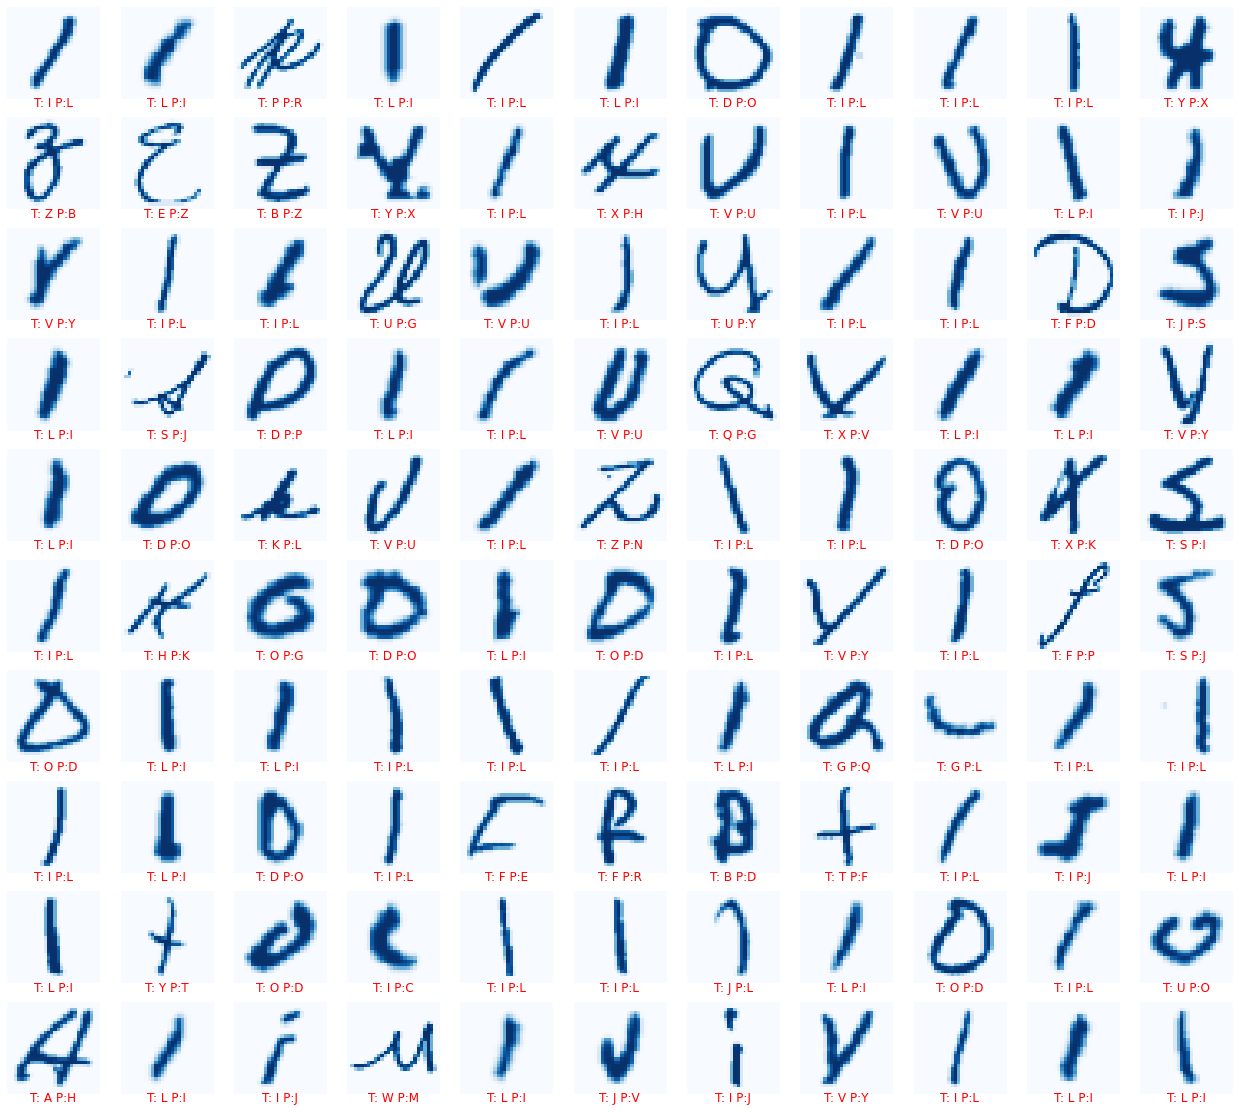

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
rows = 10
cols = 11
X = X_val
y = y_val
y_p = np.argmax(model.predict(X),axis =1)
fig = plt.figure()
fig.set_size_inches(15,15)
cm = confusion_matrix(y, y_p)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
names = target_names=res_mapper.values()
ticks = np.arange(len(names))
plt.xticks(ticks, names)
plt.yticks(ticks, names)
plt.title('Confusion matrix ')
plt.colorbar()
plt.grid()
plt.savefig("confusion_matrix.png")
plt.show()

report  = classification_report(y, y_p, target_names=res_mapper.values())
print(report)


mistakes = (y!=y_p).values
print(f"number of mistakes overall: {mistakes.sum()}")
f = plt.figure(figsize=(2*cols,2*rows))
sub_plot = 1

y_m = y[mistakes]
y_p_m =y_p[mistakes]
x_m = X[mistakes]
print("example mistakes")
for label, prediction, image in zip(y_m, y_p_m, x_m):
  if sub_plot>rows*cols:
    break
  f.add_subplot(rows,cols,sub_plot) 
  sub_plot+=1


  plt.imshow(np.transpose(image.reshape([IMAGE_SIZE,IMAGE_SIZE])),cmap="Blues")
  plt.axis("off")
  plt.title("T: "+res_mapper[label]+" P:"+res_mapper[prediction], y=-0.15,color="Red")
plt.savefig("error_plots.png")
plt.show()

## model save

In [11]:
import json
 
# serialize model to JSON
model_json = model.to_json()
with open(f"{path_to_model}model_{TYPE}.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(f"{path_to_model}model_{TYPE}.h5")

 
with open(f"{path_to_model}model_{TYPE}_mapping.json", "w") as json_file:
    json.dump(res_mapper, json_file)
    

print("Saved model to disk")


Saved model to disk


# Testing the model

## model load

In [12]:
from keras.models import model_from_json

test_db  = pd.read_csv(path_to_data + "emnist-balanced-enriched-test.csv")
test_filtered = filter_type(test_db)
y = test_filtered.iloc[:,0] - to_substract

X = (
    test_filtered.iloc[:,1:]
    .values
    .reshape([len(test_filtered),IMAGE_SIZE,IMAGE_SIZE,1])/255
)

# load json and create model
json_file = open(path_to_model + f'model_{TYPE}.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(path_to_model + f'model_{TYPE}.h5')
print("Loaded model from disk")
 
# evaluate loaded model on test data
initial_lr = 0.001
loss = "sparse_categorical_crossentropy"
model.compile(Adam(lr=initial_lr), loss=loss ,metrics=['accuracy'])

y_p = np.argmax(model.predict(X),axis =1)

Loaded model from disk


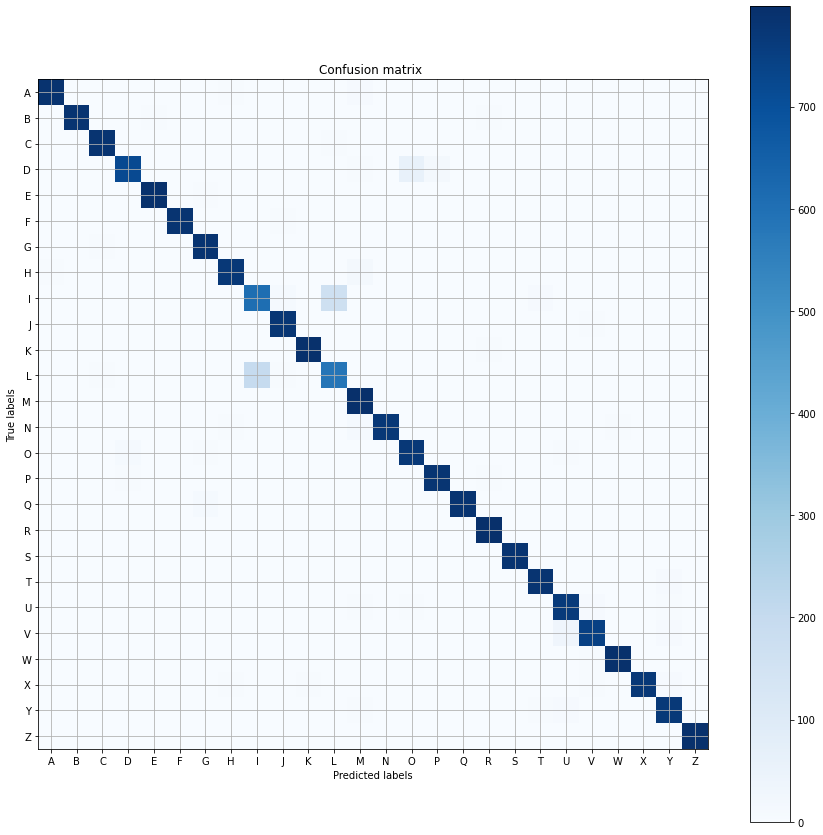

              precision    recall  f1-score   support

           A       0.99      0.98      0.98       800
           B       0.99      0.98      0.98       800
           C       0.98      0.98      0.98       800
           D       0.97      0.90      0.93       800
           E       0.99      0.99      0.99       800
           F       0.98      0.98      0.98       800
           G       0.97      0.98      0.97       800
           H       0.98      0.96      0.97       800
           I       0.75      0.76      0.75       800
           J       0.96      0.97      0.96       800
           K       0.98      0.99      0.99       800
           L       0.77      0.73      0.75       800
           M       0.93      1.00      0.96       800
           N       0.98      0.97      0.98       800
           O       0.92      0.97      0.94       800
           P       0.97      0.98      0.97       800
           Q       0.98      0.98      0.98       800
           R       0.98    

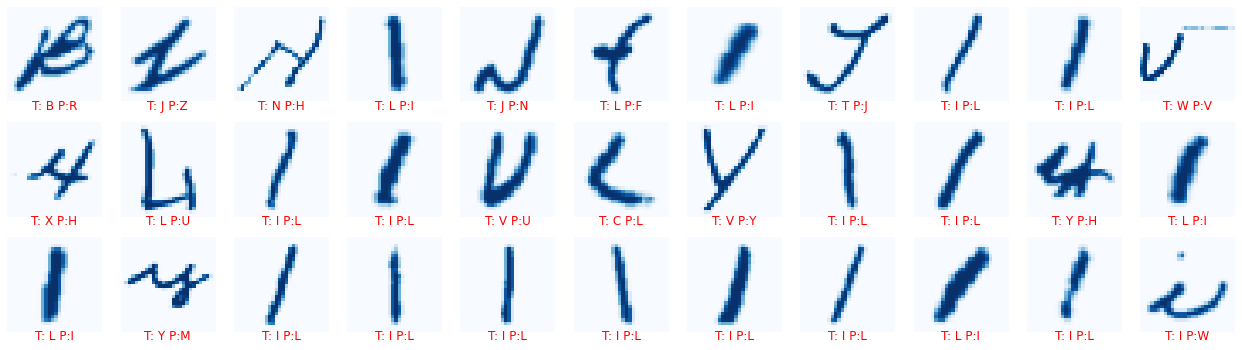

In [13]:

fig = plt.figure()
fig.set_size_inches(15,15)
cm = confusion_matrix(y, y_p)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
names = target_names=res_mapper.values()
ticks = np.arange(len(names))
plt.xticks(ticks, names)
plt.yticks(ticks, names)
plt.title('Confusion matrix ')
plt.colorbar()
plt.grid()
plt.show()

report  = classification_report(y, y_p, target_names=res_mapper.values())
print(report)


rows = 3
cols = 11
mistakes = (y!=y_p).values
print(f"number of mistakes overall: {mistakes.sum()}")
f = plt.figure(figsize=(2*cols,2*rows))
sub_plot = 1

y_m = y[mistakes]
y_p_m =y_p[mistakes]
x_m = X[mistakes]
print("example mistakes")
for label, prediction, image in zip(y_m, y_p_m, x_m):
  if sub_plot>rows*cols:
    break
  f.add_subplot(rows,cols,sub_plot) 
  sub_plot+=1


  plt.imshow(np.transpose(image.reshape([IMAGE_SIZE,IMAGE_SIZE])),cmap="Blues")
  plt.axis("off")
  plt.title("T: "+res_mapper[label]+" P:"+res_mapper[prediction], y=-0.15,color="Red")
plt.savefig("error_plots.png")
plt.show()

## Display data from dataset

## data from our forms

In [0]:
from structure_parser.formstructureparser import FormStructureParser
from field_recognizer.recognize_all import recognize
from preprocessing.preprocess import preprocess
import json
from field_recognizer.model import load_model, load_result_mapper
from main import process_document, output_data
image_path = path_to_forms + "scan1.jpg"
with open(path_to_forms + "config.json", 'r') as f:
    config = json.load(f) 

fsp = FormStructureParser(config)

im = cv2.imread(image_path)

im = preprocess(im, config)
form_data = fsp.process_form(im)

In [0]:
imgs = [im for field in form_data["fields"] for im in field["box_data"] if field["type"] ==TYPE]

In [0]:
# preproces to training format
from field_recognizer.recognize_letters import preprocess_img, prepare_for_model_format, resize, thicken

def predict(img):
  img_m = 1-img.reshape(1,IMAGE_SIZE,IMAGE_SIZE,1).transpose()/255  
  
  pred = model.predict(img_m)
  pred_val = res_mapper.get(pred[0].argmax())
  
  conf_dict = {res_mapper.get(i):round(v,3) for i,v in enumerate(pred[0])}
  conf_dict = {k: v for k, v in sorted(conf_dict.items(), key=lambda item: item[1], reverse=True) if v>0} # sort
  print(pred_val)
  print(conf_dict)



original:


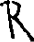

preprocessed:


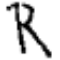

R
{'R': 1.0}
original:


preprocessed:


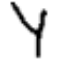

Y
{'Y': 1.0}
original:


preprocessed:


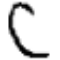

C
{'C': 0.999}
original:


preprocessed:


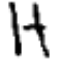

H
{'H': 0.999, 'M': 0.001}
original:


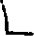

preprocessed:


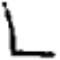

L
{'L': 0.999, 'K': 0.001}
original:


preprocessed:


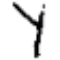

Y
{'Y': 1.0}
original:


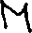

preprocessed:


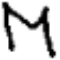

M
{'M': 1.0}
original:


preprocessed:


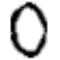

O
{'O': 0.932, 'Q': 0.067, 'C': 0.001, 'D': 0.001}
original:


preprocessed:


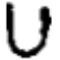

U
{'U': 0.992, 'Y': 0.007, 'V': 0.001}
original:


preprocessed:


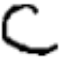

C
{'C': 1.0}
original:


preprocessed:


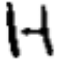

H
{'H': 1.0}
original:


preprocessed:


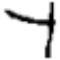

Y
{'Y': 0.94, 'H': 0.055, 'T': 0.003, 'U': 0.001, 'V': 0.001}


In [17]:
for img in [img for img in imgs if len(img)>0]:
    print ("=================================")
    print("original:")
    display(PIL.Image.fromarray(img))
    img = resize(img,28,1)
    # img = resize(thicken(img),28,4)
    # img = preprocess_img(img)
    print("preprocessed:")
    display(PIL.Image.fromarray(cv2.resize(img,(60,60))))
    predict(img)